# THE BATTLE OF NEIGHBORHOODS

# Introduction:

New York City's demographics show that it is a large and ethnically diverse metropolis. With it's diverse culture , comes diverse food items. There are many resturants in New york City, each beloning to different categories like Chinese , Indian , French etc.

So as part of this project , we will list and visualize all major parts of New York City that has great chinese resturants.

# Data:

For this project we need the following data:
1. New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude.
2. Chinese resturants in each neighborhood of new york city.
3. GeoSpace data

## Questions that will be answers at the end of this project :

### 1. What are best location in New York City for Chinese Cuisine?
### 2. Which areas have potential Chinese Restaurant Market?
### 3. Which all areas lack Chinese Restaurants?
### 4. Which is the best place to stay if you prefer Chinese Cuisine?

# Methodology:

1. We begin by collecting the New York city data from "https://cocl.us/new_york_dataset".
2. We will find all venues for each neighborhood using FourSquare API.
3. We will then filter out all Chinese Restuarant venues.
4. Next using FourSquare API, we will find the Ratings, Tips, and Like count for all the Chinese Resturants.
5. Next we will sort the data keeping Ratings as the constraint.
6. Finally, we will visualize the Ranking of neighborhoods using python's Folium library.

Lets Start by importing the required Libraries.

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import geocoder
import os
#!pip install folium
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [3]:
def get_venues(lat,lng):
    
    #set variables
    radius=500
    LIMIT=100
    CLIENT_ID = 'KGQI2XHG05DMAXJUMWXL0DBSENZFW4PWFIMKGRU10X2TXGIZ' # your Foursquare ID
    CLIENT_SECRET = 'XLLHCSN5TT5VCMAN4XUJBRX3R2M5UNUZQKIWM52SJLAYVUDK' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    LIMIT = 100
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [4]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'KGQI2XHG05DMAXJUMWXL0DBSENZFW4PWFIMKGRU10X2TXGIZ' # your Foursquare ID
    CLIENT_SECRET = 'XLLHCSN5TT5VCMAN4XUJBRX3R2M5UNUZQKIWM52SJLAYVUDK' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API versio
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [5]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

We will call the above funtion to get the new york city data.

In [6]:
new_york_data=get_new_york_data()

In [7]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
new_york_data.shape

(306, 4)

### The above result shows that there are 306 different Neighborhoods in New York.

Now let create a BAR PLOT to show different Neighborhoods in New York.

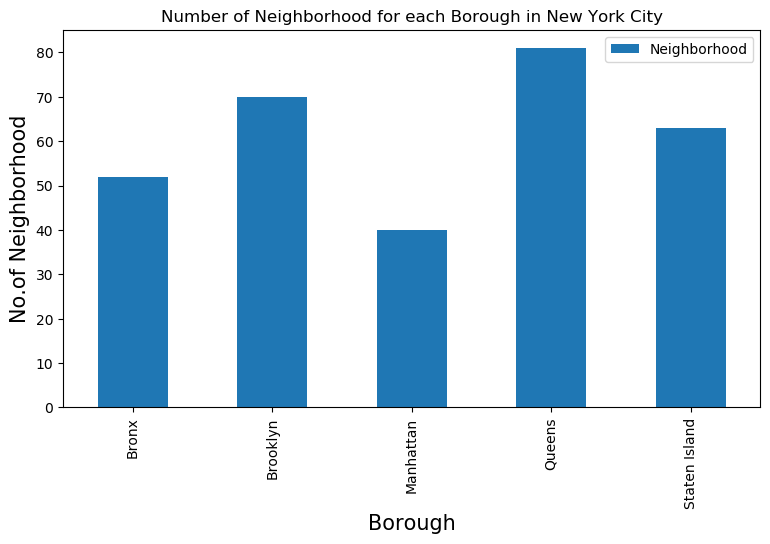

In [9]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

### From the above Bar Plot, we can see that Queens has highest number of neighborhoods.

Next we will collect Chinese resturants for each Neighborhood.

In [12]:
# prepare neighborhood list that contains chinese resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
chinese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    chinese_resturants=venues[venues['Category']=='Chinese Restaurant']   
    print('(',count,'/',len(new_york_data),')','Chinese Resturants in '+Neighborhood+', '+Borough+':'+str(len(chinese_resturants)))
    for resturant_detail in chinese_resturants.values.tolist():
        id, name , category=resturant_detail
        chinese_rest_ny = chinese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Chinese Resturants in Wakefield, Bronx:0
( 2 / 306 ) Chinese Resturants in Co-op City, Bronx:0
( 3 / 306 ) Chinese Resturants in Eastchester, Bronx:1
( 4 / 306 ) Chinese Resturants in Fieldston, Bronx:0
( 5 / 306 ) Chinese Resturants in Riverdale, Bronx:0
( 6 / 306 ) Chinese Resturants in Kingsbridge, Bronx:1
( 7 / 306 ) Chinese Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Chinese Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Chinese Resturants in Norwood, Bronx:1
( 10 / 306 ) Chinese Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Chinese Resturants in Baychester, Bronx:0
( 12 / 306 ) Chinese Resturants in Pelham Parkway, Bronx:1
( 13 / 306 ) Chinese Resturants in City Island, Bronx:0
( 14 / 306 ) Chinese Resturants in Bedford Park, Bronx:3
( 15 / 306 ) Chinese Resturants in University Heights, Bronx:2
( 16 / 306 ) Chinese Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Chinese Resturants in Fordham, Bronx:1
( 18 / 306 ) Chinese Resturants in East Tremont, Bronx:

( 141 / 306 ) Chinese Resturants in Sunnyside, Queens:3
( 142 / 306 ) Chinese Resturants in East Elmhurst, Queens:0
( 143 / 306 ) Chinese Resturants in Maspeth, Queens:3
( 144 / 306 ) Chinese Resturants in Ridgewood, Queens:0
( 145 / 306 ) Chinese Resturants in Glendale, Queens:0
( 146 / 306 ) Chinese Resturants in Rego Park, Queens:0
( 147 / 306 ) Chinese Resturants in Woodhaven, Queens:0
( 148 / 306 ) Chinese Resturants in Ozone Park, Queens:1
( 149 / 306 ) Chinese Resturants in South Ozone Park, Queens:0
( 150 / 306 ) Chinese Resturants in College Point, Queens:1
( 151 / 306 ) Chinese Resturants in Whitestone, Queens:0
( 152 / 306 ) Chinese Resturants in Bayside, Queens:2
( 153 / 306 ) Chinese Resturants in Auburndale, Queens:0
( 154 / 306 ) Chinese Resturants in Little Neck, Queens:4
( 155 / 306 ) Chinese Resturants in Douglaston, Queens:1
( 156 / 306 ) Chinese Resturants in Glen Oaks, Queens:0
( 157 / 306 ) Chinese Resturants in Bellerose, Queens:2
( 158 / 306 ) Chinese Resturants

( 276 / 306 ) Chinese Resturants in Stuyvesant Town, Manhattan:0
( 277 / 306 ) Chinese Resturants in Flatiron, Manhattan:0
( 278 / 306 ) Chinese Resturants in Sunnyside Gardens, Queens:1
( 279 / 306 ) Chinese Resturants in Blissville, Queens:0
( 280 / 306 ) Chinese Resturants in Fulton Ferry, Brooklyn:0
( 281 / 306 ) Chinese Resturants in Vinegar Hill, Brooklyn:0
( 282 / 306 ) Chinese Resturants in Weeksville, Brooklyn:1
( 283 / 306 ) Chinese Resturants in Broadway Junction, Brooklyn:0
( 284 / 306 ) Chinese Resturants in Dumbo, Brooklyn:0
( 285 / 306 ) Chinese Resturants in Manor Heights, Staten Island:1
( 286 / 306 ) Chinese Resturants in Willowbrook, Staten Island:1
( 287 / 306 ) Chinese Resturants in Sandy Ground, Staten Island:0
( 288 / 306 ) Chinese Resturants in Egbertville, Staten Island:0
( 289 / 306 ) Chinese Resturants in Roxbury, Queens:0
( 290 / 306 ) Chinese Resturants in Homecrest, Brooklyn:2
( 291 / 306 ) Chinese Resturants in Middle Village, Queens:0
( 292 / 306 ) Chine

Now that we have got all the Chinese resturants in new york city , we will analyze it.

In [13]:
chinese_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Eastchester,4dabc3dc93a04642f09ccabd,Xing Lung Chinese Restaurant
1,Bronx,Kingsbridge,4e3b11c98877b00cfc27a483,Guan Hin Restaurant
2,Bronx,Norwood,4ce313fc438b224bbc6c80a3,Happy Dragon
3,Bronx,Pelham Parkway,4b9d6b45f964a52078ab36e3,Mr. Q's Chinese Restaurant
4,Bronx,Bedford Park,4e2e08021838f1c552b6b8eb,Choi Yuan - Chinese Restaurant


In [14]:
chinese_rest_ny.shape

(209, 4)

### From the above result, we see that there are 209 chinese Resturants across New York City.

Now let create a BAR PLOT to show Number of Chinese Resturants for each Borough in New York City.

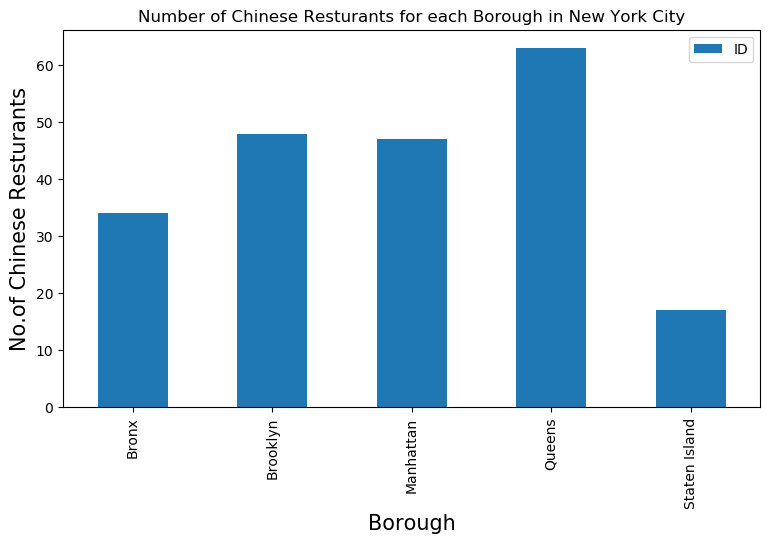

In [15]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Chinese Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Chinese Resturants', fontsize=15)
#giving a bar plot
chinese_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

### From the above Bar Plot, we can see that Queens has highest number of Chinese resturants.

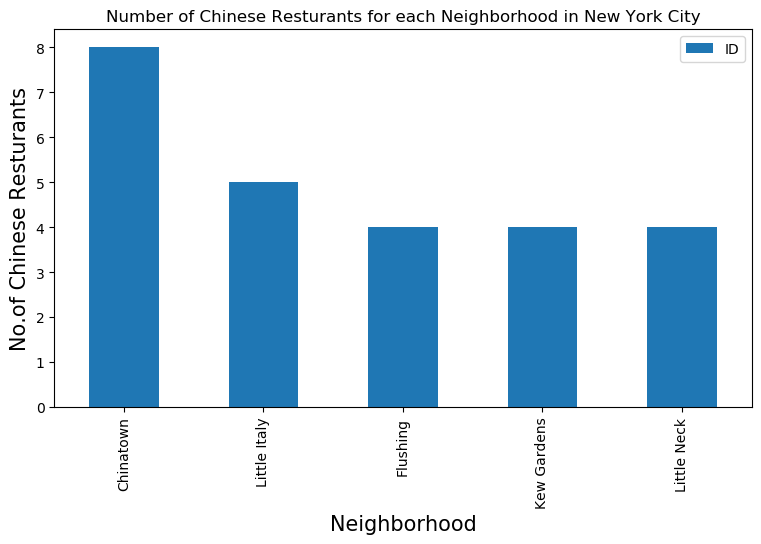

In [16]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Chinese Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Chinese Resturants', fontsize=15)
#giving a bar plot
chinese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [17]:
chinese_rest_ny[chinese_rest_ny['Neighborhood']=='Chinatown']

,Borough,Neighborhood,ID,Name
63,Manhattan,Chinatown,4db3374590a0843f295fb69b,Spicy Village
64,Manhattan,Chinatown,4a96bf8ff964a520ce2620e3,Wah Fung Number 1 Fast Food 華豐快飯店
65,Manhattan,Chinatown,5894c9a15e56b417cf79e553,Xi'an Famous Foods
66,Manhattan,Chinatown,59d828f0916bc1155fde2c04,Hwa Yuan
67,Manhattan,Chinatown,59ad625a2619ee5cdded881f,House Special 甘來飯店
68,Manhattan,Chinatown,3fd66200f964a520b1ea1ee3,Great N.Y. Noodletown
69,Manhattan,Chinatown,4c7ab2ac2d3ba143bb1d92d0,Sun's Organic Tea Shop
70,Manhattan,Chinatown,49ff2ae8f964a520e66f1fe3,Famous Sichuan


### We can see that, ChinaTown in Queens has the highest number of Chinese Resturants with a total count of 8.

Now we will get the ranking of each resturant for further analysis.

In [18]:
# prepare neighborhood list that contains chinese resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
chinese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in chinese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(chinese_rest_ny),')','processed')
    chinese_rest_stats_ny = chinese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4dabc3dc93a04642f09ccabd
( 1 / 209 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4e3b11c98877b00cfc27a483
( 2 / 209 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4ce313fc438b224bbc6c80a3
( 3 / 209 ) processed
                         ID                        Name  Likes  Rating  Tips
0  4b9d6b45f964a52078ab36e3  Mr. Q's Chinese Restaurant      9     7.2    10
( 4 / 209 ) processed
                         ID                            Name  Likes  Rating  \
0  4e2e08021838f1c552b6b8eb  Choi Yuan - Chinese Restaurant      6     7.0   

   Tips  
0     7  
( 5 / 209 ) processed
                         ID                          Name  Likes  Rating  Tips
0  4e4d0387bd413c4cc66dfd72  Hung Hing Chinese Restaurant      5     6.0     2
( 6 / 209 ) processed
Empty DataFrame
Columns: 

                         ID       Name  Likes  Rating  Tips
0  585d72449f25836f2b2b7a1b  Xifu Food     28     8.0    13
( 56 / 209 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4d86582e81fdb1f7712424c0
( 57 / 209 ) processed
                         ID                Name  Likes  Rating  Tips
0  58df00318cfe546addb99246  Birds of a Feather    341     8.9    71
( 58 / 209 ) processed
                         ID              Name  Likes  Rating  Tips
0  54b318a1498eb29e9541053a  Wei Williamsburg     36     8.1    10
( 59 / 209 ) processed
                         ID                Name  Likes  Rating  Tips
0  58df00318cfe546addb99246  Birds of a Feather    341     8.9    71
( 60 / 209 ) processed
                         ID           Name  Likes  Rating  Tips
0  4b512cbaf964a520f64527e3  ha ha chinese      4     7.5     4
( 61 / 209 ) processed
                         ID       Name  Likes  Rating  Tips
0  4c61d131de1b2d7f7ed5e07

Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4c60846512e5c928dd6e1f4c
( 110 / 209 ) processed
                         ID                        Name  Likes  Rating  Tips
0  56296f14498edb1ed77b64a3  Five Loaves and Two Fishes     10     7.9     1
( 111 / 209 ) processed
                         ID          Name  Likes  Rating  Tips
0  4eaf0752d3e30d448393b841  Lao Bei Fang     81     8.3    50
( 112 / 209 ) processed
                         ID           Name  Likes  Rating  Tips
0  4ba57b0af964a5205f0b39e3  Empire Buffet     19     6.1     5
( 113 / 209 ) processed
                         ID                           Name  Likes  Rating  \
0  4b68c90ff964a520da8c2be3  Great Wall Chinese Restaurant      7     7.5   

   Tips  
0     2  
( 114 / 209 ) processed
                         ID             Name  Likes  Rating  Tips
0  4c350ac6452620a1502b260f  New China Fresh      4     6.4     4
( 115 / 209 ) processed
                       

Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4bba114353649c74889148fb
( 164 / 209 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4b9e559af964a520c4da36e3
( 165 / 209 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4c02eb2e39d476b0e9652fa7
( 166 / 209 ) processed
                         ID        Name  Likes  Rating  Tips
0  4c59c1d3d3aee21ea2066955  China King      4     7.0     3
( 167 / 209 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4d8a72396daeb60cd8f064e0
( 168 / 209 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4ba16a96f964a5200ab537e3
( 169 / 209 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4c858222d34ca1430e524880
( 170 / 209 ) processed
  

In [19]:
chinese_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Eastchester,0,0,0,0,0
1,Bronx,Kingsbridge,0,0,0,0,0
2,Bronx,Norwood,0,0,0,0,0
3,Bronx,Pelham Parkway,4b9d6b45f964a52078ab36e3,Mr. Q's Chinese Restaurant,9,7.2,10
4,Bronx,Bedford Park,4e2e08021838f1c552b6b8eb,Choi Yuan - Chinese Restaurant,6,7,7


In [20]:
chinese_rest_stats_ny.shape

(209, 7)

In [21]:
chinese_rest_ny.shape

(209, 4)

Now that we got data for all resturants Now lets save this data to a csv sheet. In case we by mistake modify it. As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required.

In [22]:
chinese_rest_stats_ny.to_csv('chinese_rest_stats_ny.csv', index=False)

Lets verify the data from saved csv file.

In [23]:
chinese_rest_stats_ny_csv=pd.read_csv('chinese_rest_stats_ny.csv')

In [24]:
chinese_rest_stats_ny_csv.shape

(209, 7)

In [25]:
chinese_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Eastchester,0,0,0,0.0,0
1,Bronx,Kingsbridge,0,0,0,0.0,0
2,Bronx,Norwood,0,0,0,0.0,0
3,Bronx,Pelham Parkway,4b9d6b45f964a52078ab36e3,Mr. Q's Chinese Restaurant,9,7.2,10
4,Bronx,Bedford Park,4e2e08021838f1c552b6b8eb,Choi Yuan - Chinese Restaurant,6,7.0,7


In [26]:
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 7 columns):
Borough         209 non-null object
Neighborhood    209 non-null object
ID              209 non-null object
Name            209 non-null object
Likes           209 non-null object
Rating          209 non-null object
Tips            209 non-null object
dtypes: object(7)
memory usage: 11.6+ KB


The Data type of 'Likes' and  'Tips' are of type 'String'. we will convert them into type 'Float' for further analysis.

In [31]:
chinese_rest_stats_ny['Likes']=chinese_rest_stats_ny['Likes'].astype('float64')
chinese_rest_stats_ny['Tips']=chinese_rest_stats_ny['Tips'].astype('float64')
chinese_rest_stats_ny['Rating']=chinese_rest_stats_ny['Rating'].astype('float64')

In [32]:
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 7 columns):
Borough         209 non-null object
Neighborhood    209 non-null object
ID              209 non-null object
Name            209 non-null object
Likes           209 non-null float64
Rating          209 non-null float64
Tips            209 non-null float64
dtypes: float64(3), object(4)
memory usage: 11.6+ KB


Now we will find the Chinese restuarants with Maximum Likes, Maximum Ratings and Maximum Tips.

In [33]:
# Resturant with maximum Likes
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1487
Rating                               8.8
Tips                                 521
Name: 93, dtype: object

In [34]:
# Resturant with maximum Rating
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood             Lower East Side
ID              5b380f649deb7d00399fdf9d
Name               Kings County Imperial
Likes                                 67
Rating                               9.2
Tips                                  10
Name: 96, dtype: object

In [35]:
# Resturant with maximum Tips
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1487
Rating                               8.8
Tips                                 521
Name: 93, dtype: object

Next lets visualize neighborhood with maximum average rating of resturants.

In [36]:
ny_neighborhood_stats=chinese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [37]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
125,West Village,9.00
128,Windsor Terrace,8.90
91,North Side,8.90
20,Chelsea,8.80
85,Murray Hill,8.75
89,Noho,8.70
81,Midtown South,8.70
37,East Village,8.70
120,Upper West Side,8.60
112,South Side,8.50


### Above are the top neighborhoods with top average rating of Chinese resturants.

Similarly we will find the average rating of Chinese Resturants for each Borough.

In [38]:
ny_borough_stats=chinese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [39]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,7.585106
1,Brooklyn,4.395833
3,Queens,3.836508
4,Staten Island,2.052941
0,Bronx,2.032353


Lets Visualize it.

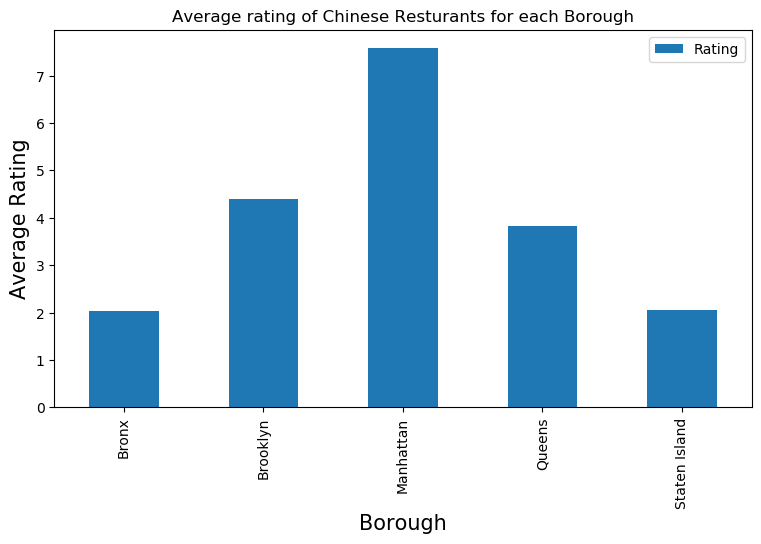

In [40]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Chinese Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
chinese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 9.0 to visualize on map.

In [41]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]

In [42]:
ny_neighborhood_stats

,Neighborhood,Average Rating
125,West Village,9.0


We will join this dataset to original new york data to get lonitude and latitude.

In [43]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [44]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [45]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,West Village,40.734434,-74.00618,9.0


In [54]:
ny_map = folium.Map(location=geo_location('New York City, NY'), zoom_start=12)

In [55]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the neighborhood and add each to the feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [56]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [57]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

# Conclusion:

### So now we can answer the questions asked above in the Questions section of the notebook.
### From our anaysis the answers to the above questions are:

#### A1) West Village(Manhattan), Windsor Terrace(Brooklyn), North Side(Brooklyn) are some of the best neighborhoods for Chinese cuisine.
#### A2) Manhattan have potential Chinese Resturant Market.
#### A3) Bronx ranks last in average rating of Chinese Resturants.
#### A4) Manhattan is the best place to stay if you prefer Chinese Cuisine.